# Setting File location

In [632]:
import os
import glob
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from pandas.tseries.offsets import MonthEnd, DateOffset

os.chdir('/Users/shreyashgupta/Library/CloudStorage/OneDrive-UniversityofArkansas/MSEA/ECON 5813 - Economic Analytics I/Project Proposal/Data')

---------------

# 1. Loading and Modeling Stocks Data

In [633]:
# 1: Load stocks and add company names
file_paths = {
    'Amazon': 'Amazon Stock.csv',
    'Comcast': 'Comcast Stock.csv',
    'Lions Gate': 'Lions Gate Historical.csv',
    'Netflix': 'Netflix Stock Data.csv',
    'Paramount Global': 'Paramount Global Historical Prices.csv',
    'Sony': 'Sony Stock.csv',
    'Walt Disney': 'The Walt Disney Company Historical Prices.csv',
    'Warner Bros Discovery': 'Warner Bros Discovery.csv',
    'Vanguard_500': 'Vanguard 500 Historical.csv',
    'Media_Company_Index': 'Media Company index.csv'
}

# Load the datasets and convert 'Date' to datetime
stocks = {name: pd.read_csv(path, parse_dates=['Date']).assign(Company=name) for name, path in file_paths.items()}

# 2 & 3: Rename columns, and set 'Date' as index
for name, df in stocks.items():
    df.set_index('Date', inplace=True)
    df.rename(columns={col: f"{col}_{name}" for col in df.columns if col != 'Company'}, inplace=True)

# 4: Concatenate all dataframes along the columns (axis=1) using an outer join
all_stocks = pd.concat(stocks.values(), axis=1, join='outer')

# Before calculating the monthly averages, duplicate the 'Date' index into a new column
all_stocks['Date'] = all_stocks.index

# Noww calculating monthly averages
numeric_columns = all_stocks.select_dtypes(include=['float64', 'int64']).columns
stocks_monthly_avg = all_stocks[numeric_columns].resample('M').mean()

# Add the 'Date' column back into stocks_monthly_avg from all_stocks before dropping the index
stocks_monthly_avg['Date'] = all_stocks['Date'].resample('M').first()

# Renaming the index
stocks_monthly_avg.index.rename('Date_index', inplace=True)

# Drop unnecessary columns
keywords_to_drop = ['Low', 'High', 'Volume', 'Open', 'Adj Close']
columns_to_drop = stocks_monthly_avg.filter(regex='|'.join(keywords_to_drop)).columns
stocks_monthly_avg.drop(columns=columns_to_drop, inplace=True)

# Reset index to become a column instead of an index
stocks_monthly_avg.reset_index(inplace=True)

# Format both 'Date' and 'Date_index' columns to 'MM/YYYY'
stocks_monthly_avg['Date_index'] = stocks_monthly_avg['Date_index'].dt.strftime('%m/%Y')
stocks_monthly_avg['Date'] = stocks_monthly_avg['Date'].dt.strftime('%m/%Y')

/var/folders/7_/z9jxc0jj6fx4snlcjg1wby4r0000gn/T/ipykernel_8371/3407977519.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = {name: pd.read_csv(path, parse_dates=['Date']).assign(Company=name) for name, path in file_paths.items()}


In [634]:
# Verifying the table output
stocks_monthly_avg.head()

,Date_index,Close_Amazon,Close_Comcast,Close_Lions Gate,Close_Netflix,Close_Paramount Global,Close_Sony,Close_Walt Disney,Close_Warner Bros Discovery,Close_Vanguard_500,Close_Media_Company_Index,Date
0,01/1962,NaN,NaN,NaN,NaN,NaN,NaN,0.094651,NaN,NaN,NaN,01/1962
1,02/1962,NaN,NaN,NaN,NaN,NaN,NaN,0.096682,NaN,NaN,NaN,02/1962
2,03/1962,NaN,NaN,NaN,NaN,NaN,NaN,0.095162,NaN,NaN,NaN,03/1962
3,04/1962,NaN,NaN,NaN,NaN,NaN,NaN,0.090820,NaN,NaN,NaN,04/1962
4,05/1962,NaN,NaN,NaN,NaN,NaN,NaN,0.080863,NaN,NaN,NaN,05/1962


# Final Table name is <span style="color:red">stocks_monthly_avg</span>

---------------------

# 2. Loading and Modeling Economic Indicators

In [635]:
# Loading Economic Indicators 
GDP = pd.read_csv('GDP.csv') # Billions of Dollars & Seasonally Adjusted Annual Rate
Unemployment_Rate = pd.read_csv('Unemployment Rate US.csv') # This is Percent & Seasonally Adjusted

In [636]:
#Renaming a column in the Unemployment table
Unemployment_Rate.rename(columns={'LRUNTTTTUSQ156S': 'Unemployment_rate'}, inplace=True)

# Convert the dictionaries to DataFrames
GDP = pd.DataFrame(GDP)
Unemployment = pd.DataFrame(Unemployment_Rate)

# Merge the DataFrames on the 'DATE' column
Economic_Indicators = GDP.merge(Unemployment, on='DATE', how='outer')

In [637]:
# Convert 'DATE' to datetime format
Economic_Indicators['DATE'] = pd.to_datetime(Economic_Indicators['DATE'])

# Format 'DATE' as 'MM/YYYY'
Economic_Indicators['DATE'] = Economic_Indicators['DATE'].dt.strftime('%m/%Y')

In [638]:
# Renaming the 'DATE' column to 'Date'
Economic_Indicators.rename(columns={'DATE': 'Date'}, inplace=True)

In [639]:
# Convert 'Date' to datetime format for filtering (assuming it is in the format MM/YYYY)
Economic_Indicators['Date'] = pd.to_datetime(Economic_Indicators['Date'], format='%m/%Y')

# Filter the DataFrame for dates greater than or equal to January 2014
Economic_Indicators = Economic_Indicators[Economic_Indicators['Date'] >= '2013-12-30']

# Convert 'Date' back to 'MM/YYYY' format after filtering
Economic_Indicators['Date'] = Economic_Indicators['Date'].dt.strftime('%m/%Y')

In [640]:
# Verifying the table output
Economic_Indicators.tail()

,Date,GDP,Unemployment_rate
301,04/2022,25544.273,3.600000
302,07/2022,25994.639,3.566667
303,10/2022,26408.405,3.600000
304,01/2023,26813.601,3.500000
305,04/2023,27063.012,3.566667


# Final Table name is <span style="color:red">Economic_Indicators</span>

--------

# 3. Loading and Modeling all IMDB datasets

<a name="_page0_x69.69_y423.22"></a>**IMDb Dataset Legend**

<Details>

Each dataset is contained in a gzipped, tab-separated-values (TSV) formatted file in the UTF-8 character set. The first line in each file contains headers that describe what is in each column. A ‘\N’ is used to denote that a particular field is missing or null for that title/name. The available datasets are as follows:

<a name="_page0_x60.71_y555.04"></a>**title.akas.tsv.gz**

- titleId (string) - a tconst, an alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given titleId
- title (string) – the localized title
- region (string) - the region for this version of the title
- language (string) - the language of the title
- types (array) - Enumerated set of attributes for this alternative title. One or more of the following: "alternative", "dvd", "festival", "tv", "video", "working", "original", "imdbDisplay". New values may be added in the future without warning
- attributes (array) - Additional terms to describe this alternative title, not enumerated
- isOriginalTitle (boolean) – 0: not original title; 1: original title <a name="_page1_x60.71_y183.54"></a>**title.basics.tsv.gz**
- tconst (string) - alphanumeric unique identifier of the title
- titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
- primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
- originalTitle (string) - original title, in the original language
- isAdult (boolean) - 0: non-adult title; 1: adult title
- startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year ![](Aspose.Words.6ef9d709-0a24-4a63-90ff-a7a4701c44f5.002.png) endYear (YYYY) – TV Series end year. ‘\N’ for all other title types ![](Aspose.Words.6ef9d709-0a24-4a63-90ff-a7a4701c44f5.003.png) runtimeMinutes – primary runtime of the title, in minutes ![](Aspose.Words.6ef9d709-0a24-4a63-90ff-a7a4701c44f5.004.png) genres (string array) – includes up to three genres associated with the title

<a name="_page1_x60.71_y549.05"></a>**title.crew.tsv.gz**

- tconst (string) - alphanumeric unique identifier of the title
- directors (array of nconsts) - director(s) of the given title
- writers (array of nconsts) – writer(s) of the given title

<a name="_page1_x60.71_y680.87"></a>**title.episode.tsv.gz**

- tconst (string) - alphanumeric identifier of episode
- parentTconst (string) - alphanumeric identifier of the parent TV Series
- seasonNumber (integer) – season number the episode belongs to
- episodeNumber (integer) – episode number of the tconst in the TV series

<a name="_page2_x60.71_y99.65"></a>**title.principals.tsv.gz**

- tconst (string) - alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given titleId
- nconst (string) - alphanumeric unique identifier of the name/person
- category (string) - the category of job that person was in
- job (string) - the specific job title if applicable, else '\N'
- characters (string) - the name of the character played if applicable, else '\N'

<a name="_page2_x60.71_y321.35"></a>**title.ratings.tsv.gz**

- tconst (string) - alphanumeric unique identifier of the title
- averageRating – weighted average of all the individual user ratings
- numVotes - number of votes the title has received

<a name="_page2_x60.71_y453.18"></a>**name.basics.tsv.gz**

- nconst (string) - alphanumeric unique identifier of the name/person
- primaryName (string)– name by which the person is most often credited
- birthYear – in YYYY format
- deathYear – in YYYY format if applicable, else '\N'
- primaryProfession (array of strings)– the top-3 professions of the person
- knownForTitles (array of tconsts) – titles the person is known for

In [641]:
# Loading the IMDb dataset --- More about the dataset above in the toggle markdown
IMDb_Basics = pd.read_csv('IMDb Basics.tsv', sep='\t')
IMDb_Ratings = pd.read_csv('IMDb Ratings.tsv', sep='\t')

/var/folders/7_/z9jxc0jj6fx4snlcjg1wby4r0000gn/T/ipykernel_8371/2278058268.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  IMDb_Basics = pd.read_csv('IMDb Basics.tsv', sep='\t')


### 1. Cleaning IMDB_Basics
-----------

In [642]:
# Converting the data to different data types
IMDb_Basics['tconst'] = IMDb_Basics['tconst'].astype(str)
IMDb_Basics['primaryTitle'] = IMDb_Basics['primaryTitle'].astype(str)
IMDb_Basics['originalTitle'] = IMDb_Basics['originalTitle'].astype(str)
IMDb_Basics['isAdult'] = IMDb_Basics['isAdult'].astype(bool)

# Handle 'startYear'
IMDb_Basics['startYear'] = IMDb_Basics['startYear'].replace('\\N', np.nan)
IMDb_Basics['startYear'] = IMDb_Basics['startYear'].astype('float').astype('Int64')

# Handle 'endYear'
IMDb_Basics['endYear'] = IMDb_Basics['endYear'].replace('\\N', np.nan)
IMDb_Basics['endYear'] = IMDb_Basics['endYear'].astype('float').astype('Int64')

IMDb_Basics['runtimeMinutes'] = IMDb_Basics['runtimeMinutes'].astype(str)
IMDb_Basics['genres'] = IMDb_Basics['genres'].astype(str)

In [643]:
# Display all the unique types of titles present in the titleType column.
unique_title_types = IMDb_Basics['titleType'].unique()
print(unique_title_types)

['short' 'movie' 'tvShort' 'tvMovie' 'tvSeries' 'tvEpisode' 'tvMiniSeries'
 'tvSpecial' 'video' 'videoGame' 'tvPilot']


In [644]:
# Filtering DataFrame for rows where titleType is exactly 'Movie'
IMDb_Basics = IMDb_Basics[IMDb_Basics['titleType'] == 'movie']

In [645]:
IMDb_Basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,False,1894,<NA>,45,Romance
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,False,1897,<NA>,100,"Documentary,News,Sport"
498,tt0000502,movie,Bohemios,Bohemios,False,1905,<NA>,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,False,1906,<NA>,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,False,1907,<NA>,90,Drama


### 2. Cleaning IMDb_Ratings
------------

In [646]:
IMDb_Ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2002
1,tt0000002,5.8,269
2,tt0000003,6.5,1892
3,tt0000004,5.5,178
4,tt0000005,6.2,2679


In [647]:
# Inspecting the data types
IMDb_Ratings.dtypes

tconst            object
averageRating    float64
numVotes           int64
dtype: object

## Merging all IMDb Datasets

In [648]:
# Merge datasets based on 'tconst'
merged_data = IMDb_Basics.merge(IMDb_Ratings, on='tconst', how='left')

In [649]:
# Remove rows where 'averageRating' is null
merged_data = merged_data.dropna(subset=['averageRating'])

# First, ensure that 'startYear' is of a numeric type, converting any non-numeric values to NaN
merged_data['startYear'] = pd.to_numeric(merged_data['startYear'], errors='coerce')

# Then, filter out rows where 'startYear' is not between 2014 and 2023
IMDB_dataset = merged_data[(merged_data['startYear'] >= 2014) & (merged_data['startYear'] <= 2023)]

In [650]:
# Verifying the table output
IMDB_dataset.tail()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
659887,tt9916270,movie,Il talento del calabrone,Il talento del calabrone,False,2020,<NA>,84,Thriller,5.8,1445.0
659888,tt9916362,movie,Coven,Akelarre,False,2020,<NA>,92,"Drama,History",6.4,5569.0
659889,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,False,2019,<NA>,\N,"Adventure,History,War",3.5,17.0
659890,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,False,2019,<NA>,123,Drama,8.6,7.0
659895,tt9916730,movie,6 Gunn,6 Gunn,False,2017,<NA>,116,Drama,7.6,11.0


# Final Table name is <span style="color:red">IMDB_dataset</span>

# 4. Loading and Modeling Movie Revenue dataset

In [651]:
# Define the path to the files
path_to_files = '/Users/shreyashgupta/Library/CloudStorage/OneDrive-UniversityofArkansas/MSEA/ECON 5813 - Economic Analytics I/Project Proposal/Data/Gross Data/'

# Initialize an empty DataFrame for the Revenues_dataset
Revenues_dataset = pd.DataFrame()

# Define a helper function to extract the year from the filename
def get_year_from_filename(file_name):
    for month in ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]:
        if month in file_name:
            return file_name.split(month)[1].strip('.csv').strip()
    return None

# Loop through each CSV file in the directory
for file_name in os.listdir(path_to_files):
    if file_name.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(path_to_files, file_name)
        # Read the CSV file into a temporary DataFrame
        temp_df = pd.read_csv(file_path)
        # Extract the year from the file name
        year = get_year_from_filename(file_name)
        if year:
            # Assume that 'Release Date' column contains the day and abbreviated month (e.g., '17-Feb')
            # If day is missing, we'll prepend '01-' to use as a placeholder
            temp_df['Release Date'] = temp_df['Release Date'].str.extract(r'(\d+)-[A-Za-z]+', expand=False).fillna('01') + '-' + temp_df['Release Date'].str.extract(r'(\d+-)?([A-Za-z]+)', expand=False)[1] + '-' + year
            # Convert 'Release Date' to datetime format
            temp_df['Release Date'] = pd.to_datetime(temp_df['Release Date'], format='%d-%b-%Y', errors='coerce')
            # Drop rows where 'Release Date' could not be parsed
            temp_df.dropna(subset=['Release Date'], inplace=True)
            # Format 'Release Date' as 'MM/YYYY'
            temp_df['Release Date'] = temp_df['Release Date'].dt.strftime('%m/%Y')
            # Append to the main DataFrame
            Revenues_dataset = pd.concat([Revenues_dataset, temp_df], ignore_index=True)

# Remove rows with NaN 'Release Date' before dropping duplicates
Revenues_dataset.dropna(subset=['Release Date'], inplace=True)

# Drop duplicates based on the 'Release' column
Revenues_dataset = Revenues_dataset.drop_duplicates(subset='Release')

# Drop the unnecessary 'Rank' and 'Gross' columns
Revenues_dataset.drop(['Rank', 'Gross'], axis=1, inplace=True)

# Drop rows with null values in 'Total_Gross'
Revenues_dataset = Revenues_dataset.dropna(subset=['Total Gross'])

In [652]:
# Verifying the table output
Revenues_dataset.head()

,Release,Theaters,Total Gross,Release Date,Distributor
0,It Chapter Two,"4,570","$211,593,228",09/2019,Warner Bros.
1,Hustlers,"3,525","$104,963,598",09/2019,STX Entertainment
2,Downton Abbey,"3,548","$96,853,865",09/2019,Focus Features
3,Ad Astra,"3,460","$50,188,370",09/2019,Twentieth Century Fox
4,Rambo: Last Blood,"3,618","$44,819,352",09/2019,Lions Gate Films


# Final Table name is <span style="color:red">Revenues_dataset</span>

-----

# MERGING ALL DATASETS

### 1. Merging Stocks and economic indicators first

In [653]:
# Convert 'Date' columns in both DataFrames to datetime if they are not already
Economic_Indicators['Date'] = pd.to_datetime(Economic_Indicators['Date'], format='%m/%Y')
stocks_monthly_avg['Date'] = pd.to_datetime(stocks_monthly_avg['Date'], format='%m/%Y')

# Set 'Date' as index for the resampling operation
Economic_Indicators.set_index('Date', inplace=True)

# This will provide a value for each month that can be forward filled
all_months = pd.date_range(start=stocks_monthly_avg['Date'].min(), 
                           end=stocks_monthly_avg['Date'].max(), 
                           freq='MS')
Economic_Indicators = Economic_Indicators.reindex(all_months)

# Resample Economic_Indicators to have rows for each month, forward filling the data
Economic_Indicators.ffill(inplace=True)

# Now, ensure the stocks_monthly_avg DataFrame has 'Date' as an index
stocks_monthly_avg.set_index('Date', inplace=True)

# Join the two DataFrames on the 'Date' index
combined_df = stocks_monthly_avg.join(Economic_Indicators, how='left')

# Reset the index to turn 'Date' back into a column
combined_df.reset_index(inplace=True)

# Convert 'Date' back to 'MM/YYYY' format
combined_df['Date'] = combined_df['Date'].dt.strftime('%m/%Y')

In [654]:
combined_df.tail()

,Date,Date_index,Close_Amazon,Close_Comcast,Close_Lions Gate,Close_Netflix,Close_Paramount Global,Close_Sony,Close_Walt Disney,Close_Warner Bros Discovery,Close_Vanguard_500,Close_Media_Company_Index,GDP,Unemployment_rate
738,07/2023,07/2023,130.818001,42.766499,7.633000,440.328000,15.921500,92.706000,87.745499,12.820500,412.995499,220.294000,27063.012,3.566667
739,08/2023,08/2023,135.502175,45.855217,7.173043,424.058697,15.174783,84.963914,86.273913,13.201304,408.786955,224.720871,27063.012,3.566667
740,09/2023,09/2023,135.440001,45.141000,7.809500,407.321997,13.283000,84.426501,82.067001,11.313500,404.918498,226.654999,27063.012,3.566667
741,10/2023,10/2023,128.678999,43.841001,7.348000,384.119091,11.682273,83.581001,82.751999,10.437000,394.707001,226.143637,27063.012,3.566667
742,11/2023,11/2023,NaN,NaN,NaN,444.870710,12.545000,NaN,NaN,NaN,NaN,232.261250,27063.012,3.566667


### 2. Merging Revenue and IMDb datasets

In [655]:
# Merge the DataFrames on the movie titles
combined2_df = pd.merge(Revenues_dataset, IMDB_dataset, left_on='Release', right_on='primaryTitle')
combined2_df.head()

,Release,Theaters,Total Gross,Release Date,Distributor,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,It Chapter Two,"4,570","$211,593,228",09/2019,Warner Bros.,tt7349950,movie,It Chapter Two,It Chapter Two,False,2019,<NA>,169,"Drama,Fantasy,Horror",6.5,289707.0
1,Hustlers,"3,525","$104,963,598",09/2019,STX Entertainment,tt3512976,movie,Hustlers,Hustlers,False,2014,<NA>,105,Drama,7.8,30.0
2,Hustlers,"3,525","$104,963,598",09/2019,STX Entertainment,tt5503686,movie,Hustlers,Hustlers,False,2019,<NA>,110,"Comedy,Crime,Drama",6.3,105310.0
3,Downton Abbey,"3,548","$96,853,865",09/2019,Focus Features,tt6398184,movie,Downton Abbey,Downton Abbey,False,2019,<NA>,122,"Drama,Romance",7.4,60884.0
4,Ad Astra,"3,460","$50,188,370",09/2019,Twentieth Century Fox,tt2935510,movie,Ad Astra,Ad Astra,False,2019,<NA>,123,"Adventure,Drama,Mystery",6.5,253317.0


## Combining combined2_df and combined_df

In [656]:
# Convert the 'Date' and 'Release Date' columns to datetime if they are not already
combined_df['Date'] = pd.to_datetime(combined_df['Date'], format='%m/%Y')
combined2_df['Release Date'] = pd.to_datetime(combined2_df['Release Date'], format='%m/%Y')

# Merge the DataFrames on the 'Date' and 'Release Date' columns
project_dataset = pd.merge(combined_df, combined2_df, left_on='Date', right_on='Release Date')

# Convert 'Date' and 'Release Date' back to 'MM/YYYY' format
project_dataset['Date'] = project_dataset['Date'].dt.strftime('%m/%Y')
project_dataset['Release Date'] = project_dataset['Release Date'].dt.strftime('%m/%Y')

## Cleaning the Project_dataset

In [657]:
project_dataset.tail()

,Date,Date_index,Close_Amazon,Close_Comcast,Close_Lions Gate,Close_Netflix,Close_Paramount Global,Close_Sony,Close_Walt Disney,Close_Warner Bros Discovery,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
6223,06/2023,06/2023,126.380476,40.574762,8.937619,421.458093,15.94,95.760953,90.619047,12.622381,...,movie,Revoir Paris,Revoir Paris,False,2022,<NA>,105,Drama,6.8,2414.0
6224,06/2023,06/2023,126.380476,40.574762,8.937619,421.458093,15.94,95.760953,90.619047,12.622381,...,movie,Falcon Lake,Falcon Lake,False,2022,<NA>,100,"Drama,Fantasy,Romance",7.2,1673.0
6225,06/2023,06/2023,126.380476,40.574762,8.937619,421.458093,15.94,95.760953,90.619047,12.622381,...,movie,Loren & Rose,Loren & Rose,False,2022,<NA>,83,Drama,7.8,35.0
6226,06/2023,06/2023,126.380476,40.574762,8.937619,421.458093,15.94,95.760953,90.619047,12.622381,...,movie,Kings of L.A.,Kings of L.A.,False,2023,<NA>,120,"Action,Comedy,Crime",8.2,33.0
6227,06/2023,06/2023,126.380476,40.574762,8.937619,421.458093,15.94,95.760953,90.619047,12.622381,...,movie,Millie Lies Low,Millie Lies Low,False,2021,<NA>,100,"Comedy,Drama",5.7,166.0


In [658]:
project_dataset.columns

Index(['Date', 'Date_index', 'Close_Amazon', 'Close_Comcast',
       'Close_Lions Gate', 'Close_Netflix', 'Close_Paramount Global',
       'Close_Sony', 'Close_Walt Disney', 'Close_Warner Bros Discovery',
       'Close_Vanguard_500', 'Close_Media_Company_Index', 'GDP',
       'Unemployment_rate', 'Release', 'Theaters', 'Total Gross',
       'Release Date', 'Distributor', 'tconst', 'titleType', 'primaryTitle',
       'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes',
       'genres', 'averageRating', 'numVotes'],
      dtype='object')

In [659]:
# Convert 'Total_Gross' to numeric by removing '$' and ',' then converting to float
# Use a raw string for the regular expression
project_dataset['Total Gross'] = project_dataset['Total Gross'].replace(r'[\$,]', '', regex=True).astype(float)

# Filter out rows where 'Total_Gross' is less than 4 million
project_dataset = project_dataset[project_dataset['Total Gross'] >= 4000000]

# Remove specified columns
columns_to_remove = ['startYear', 'titleType', 'tconst', 'Date_index', 'endYear']
project_dataset = project_dataset.drop(columns=columns_to_remove, errors='ignore') 

In [660]:
project_dataset.head()

,Date,Close_Amazon,Close_Comcast,Close_Lions Gate,Close_Netflix,Close_Paramount Global,Close_Sony,Close_Walt Disney,Close_Warner Bros Discovery,Close_Vanguard_500,...,Total Gross,Release Date,Distributor,primaryTitle,originalTitle,isAdult,runtimeMinutes,genres,averageRating,numVotes
2,01/2014,19.743167,26.469762,NaN,51.304082,60.758572,17.042381,74.264285,42.071684,166.779048,...,64251541.0,01/2014,Open Road Films (II),The Nut Job,The Nut Job,False,85,"Adventure,Animation,Comedy",5.7,29715.0
3,01/2014,19.743167,26.469762,NaN,51.304082,60.758572,17.042381,74.264285,42.071684,166.779048,...,134938200.0,01/2014,Universal Pictures,Ride Along,Ride Along,False,99,"Action,Comedy,Crime",6.1,120592.0
4,01/2014,19.743167,26.469762,NaN,51.304082,60.758572,17.042381,74.264285,42.071684,166.779048,...,26068955.0,01/2014,Focus Features,That Awkward Moment,That Awkward Moment,False,94,"Comedy,Romance",6.1,106098.0
5,01/2014,19.743167,26.469762,NaN,51.304082,60.758572,17.042381,74.264285,42.071684,166.779048,...,50577412.0,01/2014,Paramount Pictures,Jack Ryan: Shadow Recruit,Jack Ryan: Shadow Recruit,False,105,"Action,Drama,Thriller",6.2,136516.0
6,01/2014,19.743167,26.469762,NaN,51.304082,60.758572,17.042381,74.264285,42.071684,166.779048,...,19075290.0,01/2014,Lions Gate Films,"I, Frankenstein","I, Frankenstein",False,92,"Action,Fantasy,Sci-Fi",5.1,83067.0


<a name="_page0_x69.69_y423.22"></a>**All distribution companies list grouping**

<Details>

All the companies I have
    Amazon
    Comcast
    Lions Gate
    Netflix
    Paramount Global
    Sony
    Walt Disney
    Warner Bros Discovery

Owned by or Part of Companies in List 2:
    Universal Pictures - Owned by Comcast
    Focus Features - Owned by Comcast
    Paramount Pictures - Part of Paramount Global
    Lions Gate Films - Part of Lions Gate
    Twentieth Century Fox - Now part of Walt Disney (rebranded as 20th Century Studios)
    Warner Bros. - Part of Warner Bros Discovery
    Sony Pictures Entertainment (SPE) - Part of Sony
    TriStar Pictures - Part of Sony
    Screen Gems - Part of Sony
    Walt Disney Studios Motion Pictures - Part of Walt Disney
    Sony Pictures Classics - Part of Sony
    The Samuel Goldwyn Company - Has historical ties to MGM, which is now part of Amazon
    UTV Motion Pictures - Owned by Walt Disney through its Indian subsidiary
    CBS Films - Part of Paramount Global
    Amazon Studios - Owned by Amazon
    20th Century Studios - Owned by Walt Disney
    Searchlight Pictures - Owned by Walt Disney
    Columbia Pictures - Owned by Sony
    Netflix - Owned by Netflix
    DreamWorks: Owned by Paramount
    Metro-Goldwyn-Mayer (MGM): Owned by Amazon
    Crunchyroll: Owned by Sony
    Roadside Attractions: Part of Lions Gate
    Pure Flix Entertainment: Owned by Sony
    Blue Sky Cinema: Owned by Walt Disney
    FUNimation Entertainment: Owned by Sony
    The Orchard: Owned by Sony
    Pantelion Films: Part of Lionsgate
    Affirm Films: Part of Sony
    Orion Pictures: Part of Amazon
    National Geographic Entertainment: Owned by Walt Disney
    United Artists Releasing: Owned by Amazon
    Entertainment One: Lionsgate
    Saban Films: Owned by Walt Disney

Not Owned by or Part of Companies in List 2:
    Open Road Films (II)
    Relativity Media
    STX Entertainment
    RADiUS-TWC
    The Weinstein Company
    Freestyle Releasing
    Clarius Entertainment
    IFC Films
    Cohen Media Group
    Purdie Distribution
    A24
    Bleecker Street Media
    Eros Worldwide
    Broad Green Pictures
    EuropaCorp
    FIP
    BH Tilt
    The Film Arcade
    Yash Raj Films
    Magnolia Pictures
    Great India Films
    Entertainment Studios Motion Pictures
    Annapurna Pictures
    Aviron Pictures
    Good Deed Entertainment
    Atlas Distribution Company
    Viva Pictures
    Neon
    Vertical Entertainment
    Studio 8
    LD Entertainment
    Briarcliff Entertainment
    Trafalgar Releasing
    IMAX
    Greenwich Entertainment
    101 Studios
    Reliance Big Pictures
    GKIDS
    truTV
    Solstice Studios
    Cloudburst Entertainment
    Fathom Events
    Reliance Entertainment
    Sarigama Cinemas
    Cinedigm Entertainment Group
    Yash Raj Films USA Inc.
    Well Go USA Entertainment
    Angel Studios
    Soli Deo Gloria Releasing
    Ketchup Entertainment

In [661]:
# Updated list of distributors to be removed
distributors_to_remove = [
    "Open Road Films (II)", "Relativity Media", "STX Entertainment", "RADiUS-TWC",
    "The Weinstein Company", "Freestyle Releasing", "Clarius Entertainment", 
    "IFC Films", "Cohen Media Group", "Purdie Distribution", "A24", 
    "Bleecker Street Media", "Eros Worldwide", "Broad Green Pictures", "EuropaCorp", 
    "FIP", "BH Tilt", "The Film Arcade", "Yash Raj Films", "Magnolia Pictures", 
    "Great India Films", "Entertainment Studios Motion Pictures", "Annapurna Pictures", 
    "Aviron Pictures", "Good Deed Entertainment", "Atlas Distribution Company", 
    "Viva Pictures", "Neon", "Vertical Entertainment", "Studio 8", "LD Entertainment", 
    "Briarcliff Entertainment", "Trafalgar Releasing", "IMAX", "Greenwich Entertainment", 
    "101 Studios", "Reliance Big Pictures", "GKIDS", "truTV", "Solstice Studios", 
    "Cloudburst Entertainment", "Fathom Events", "Reliance Entertainment", 
    "Sarigama Cinemas", "Cinedigm Entertainment Group", "Yash Raj Films USA Inc.", 
    "Well Go USA Entertainment", "Angel Studios", "Soli Deo Gloria Releasing", 
    "Ketchup Entertainment",
]

# Removing rows with the specified distributors
project_dataset = project_dataset[~project_dataset['Distributor'].isin(distributors_to_remove)]

In [662]:
# Grouping the media companies into the companies they are owned by or the companies by themselves.
distributor_to_parent_map = {
    "Universal Pictures": "Comcast",
    "Focus Features": "Comcast",
    "Paramount Pictures": "Paramount",
    "Lions Gate Films": "LionsGate",
    "Twentieth Century Fox": "Walt Disney",
    "Warner Bros.": "Warner Bros Discovery",
    "Sony Pictures Entertainment (SPE)": "Sony",
    "TriStar Pictures": "Sony",
    "Screen Gems": "Sony",
    "Walt Disney Studios Motion Pictures": "Walt Disney",
    "Sony Pictures Classics": "Sony",
    "The Samuel Goldwyn Company": "Amazon",
    "UTV Motion Pictures": "Walt Disney",
    "CBS Films": "Paramount",
    "Amazon Studios": "Amazon",
    "20th Century Studios": "Walt Disney",
    "Searchlight Pictures": "Walt Disney",
    "Columbia Pictures": "Sony",
    "Netflix": "Netflix",
    "DreamWorks": "Paramount",
    "Metro-Goldwyn-Mayer (MGM)": "Amazon",
    "Crunchyroll": "Sony",
    "Roadside Attractions": "LionsGate",
    "Pure Flix Entertainment": "Sony",
    "Blue Sky Cinema": "Walt Disney",
    "FUNimation Entertainment": "Sony",
    "The Orchard": "Sony",
    "Pantelion Films": "LionsGate",
    "Affirm Films": "Sony",
    "Orion Pictures": "Amazon",
    "National Geographic Entertainment": "Walt Disney",
    "United Artists Releasing": "Amazon",
    "Entertainment One": "LionsGate",
    "Saban Films": "Walt Disney"
}

# Applying the mapping to the 'Distributor' column
project_dataset['Distributor'] = project_dataset['Distributor'].map(distributor_to_parent_map).fillna(project_dataset['Distributor'])

In [663]:
# filter out the rows which has a - in the Distributor column
project_dataset = project_dataset[project_dataset['Distributor'] != '-']

In [664]:
# Get all unique values in the 'Distributor' column
unique_distributors = project_dataset['Distributor'].unique()

# Print the unique values
print(unique_distributors)

['Comcast' 'Paramount' 'LionsGate' 'Walt Disney' 'Warner Bros Discovery'
 'Sony' 'Amazon' 'Netflix']


In [665]:
project_dataset.tail()

,Date,Close_Amazon,Close_Comcast,Close_Lions Gate,Close_Netflix,Close_Paramount Global,Close_Sony,Close_Walt Disney,Close_Warner Bros Discovery,Close_Vanguard_500,...,Total Gross,Release Date,Distributor,primaryTitle,originalTitle,isAdult,runtimeMinutes,genres,averageRating,numVotes
6204,06/2023,126.380476,40.574762,8.937619,421.458093,15.94,95.760953,90.619047,12.622381,399.098572,...,50452282.0,06/2023,Sony,No Hard Feelings,Wir,False,92,"Drama,Romance",6.7,1557.0
6205,06/2023,126.380476,40.574762,8.937619,421.458093,15.94,95.760953,90.619047,12.622381,399.098572,...,174480468.0,06/2023,Walt Disney,Indiana Jones and the Dial of Destiny,Indiana Jones and the Dial of Destiny,False,154,"Action,Adventure,Sci-Fi",6.7,133366.0
6206,06/2023,126.380476,40.574762,8.937619,421.458093,15.94,95.760953,90.619047,12.622381,399.098572,...,28153025.0,06/2023,Comcast,Asteroid City,Asteroid City,False,105,"Comedy,Drama,Romance",6.6,79626.0
6207,06/2023,126.380476,40.574762,8.937619,421.458093,15.94,95.760953,90.619047,12.622381,399.098572,...,17707207.0,06/2023,LionsGate,The Blackening,The Blackening,False,97,"Comedy,Horror,Thriller",6.0,13499.0
6209,06/2023,126.380476,40.574762,8.937619,421.458093,15.94,95.760953,90.619047,12.622381,399.098572,...,15753600.0,06/2023,Paramount,"Ruby Gillman, Teenage Kraken","Ruby Gillman, Teenage Kraken",False,91,"Action,Adventure,Animation",5.7,6851.0


In [666]:
project_dataset.columns

Index(['Date', 'Close_Amazon', 'Close_Comcast', 'Close_Lions Gate',
       'Close_Netflix', 'Close_Paramount Global', 'Close_Sony',
       'Close_Walt Disney', 'Close_Warner Bros Discovery',
       'Close_Vanguard_500', 'Close_Media_Company_Index', 'GDP',
       'Unemployment_rate', 'Release', 'Theaters', 'Total Gross',
       'Release Date', 'Distributor', 'primaryTitle', 'originalTitle',
       'isAdult', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes'],
      dtype='object')

### Finally adding stock prices for 1 month ahead after the release of a movie.

In [667]:
# Convert 'Date' and 'Release Date' from 'MM/YYYY' to datetime
project_dataset['Date'] = pd.to_datetime(project_dataset['Date'], format='%m/%Y')
project_dataset['Release Date'] = pd.to_datetime(project_dataset['Release Date'], format='%m/%Y')

# Calculate the first day of the next month
def next_month_first_day(date):
    # Add one month to the current date
    next_month = date + DateOffset(months=1)
    return next_month.strftime('%m/%Y')

# Apply this to the 'Release Date' column
project_dataset['Next_Month'] = project_dataset['Release Date'].apply(next_month_first_day)

# Stock columns to look up
stock_columns = ['Close_Amazon', 'Close_Comcast', 'Close_Lions Gate',
                 'Close_Netflix', 'Close_Paramount Global', 'Close_Sony',
                 'Close_Walt Disney', 'Close_Warner Bros Discovery',
                 'Close_Vanguard_500', 'Close_Media_Company_Index']

# Mapping the stock prices
for stock in stock_columns:
    project_dataset[f'Next_Month_{stock}'] = project_dataset.apply(
        lambda row: project_dataset.loc[project_dataset['Date'].dt.strftime('%m/%Y') == row['Next_Month'], stock].iloc[0]
        if not project_dataset[project_dataset['Date'].dt.strftime('%m/%Y') == row['Next_Month']][stock].empty else None, axis=1)

#Formatting the date columns to MM/YYYY
project_dataset['Date'] = project_dataset['Date'].dt.strftime('%m/%Y')
project_dataset['Release Date'] = project_dataset['Release Date'].dt.strftime('%m/%Y')

# Drop the temporary 'Next_Month' column if not needed
project_dataset.drop(columns=['Next_Month'], inplace=True)

In [668]:
# Verifying the table output
project_dataset.head()

,Date,Close_Amazon,Close_Comcast,Close_Lions Gate,Close_Netflix,Close_Paramount Global,Close_Sony,Close_Walt Disney,Close_Warner Bros Discovery,Close_Vanguard_500,...,Next_Month_Close_Amazon,Next_Month_Close_Comcast,Next_Month_Close_Lions Gate,Next_Month_Close_Netflix,Next_Month_Close_Paramount Global,Next_Month_Close_Sony,Next_Month_Close_Walt Disney,Next_Month_Close_Warner Bros Discovery,Next_Month_Close_Vanguard_500,Next_Month_Close_Media_Company_Index
3,01/2014,19.743167,26.469762,NaN,51.304082,60.758572,17.042381,74.264285,42.071684,166.779048,...,17.716842,26.391579,NaN,61.631278,63.270527,16.936316,77.578948,41.576796,166.606315,146.725789
4,01/2014,19.743167,26.469762,NaN,51.304082,60.758572,17.042381,74.264285,42.071684,166.779048,...,17.716842,26.391579,NaN,61.631278,63.270527,16.936316,77.578948,41.576796,166.606315,146.725789
5,01/2014,19.743167,26.469762,NaN,51.304082,60.758572,17.042381,74.264285,42.071684,166.779048,...,17.716842,26.391579,NaN,61.631278,63.270527,16.936316,77.578948,41.576796,166.606315,146.725789
6,01/2014,19.743167,26.469762,NaN,51.304082,60.758572,17.042381,74.264285,42.071684,166.779048,...,17.716842,26.391579,NaN,61.631278,63.270527,16.936316,77.578948,41.576796,166.606315,146.725789
7,01/2014,19.743167,26.469762,NaN,51.304082,60.758572,17.042381,74.264285,42.071684,166.779048,...,17.716842,26.391579,NaN,61.631278,63.270527,16.936316,77.578948,41.576796,166.606315,146.725789


### Adding stock prices for 2 months ahead after the release of a movie.

In [669]:
# Convert 'Release Date' to datetime
project_dataset['Release Date'] = pd.to_datetime(project_dataset['Release Date'], format='%m/%Y')
project_dataset['Date'] = pd.to_datetime(project_dataset['Date'], format='%m/%Y')

# Calculate the first day of the second month after the given date
def second_month_first_day(date):
    # Add two months to the current date
    second_month = date + pd.DateOffset(months=2)
    return second_month.strftime('%m/%Y')

# Apply this to the 'Release Date' column
project_dataset['Second_Month'] = project_dataset['Release Date'].apply(second_month_first_day)

# Mapping the stock prices two months ahead
for stock in stock_columns:
    project_dataset[f'Second_Month_{stock}'] = project_dataset.apply(
        lambda row: project_dataset.loc[project_dataset['Date'].dt.strftime('%m/%Y') == row['Second_Month'], stock].iloc[0]
        if not project_dataset[project_dataset['Date'].dt.strftime('%m/%Y') == row['Second_Month']][stock].empty else None, axis=1)

# Drop the temporary 'Second_Month' column if not needed
project_dataset.drop(columns=['Second_Month'], inplace=True)

# Convert 'Date' and 'Release Date' back to 'MM/YYYY' format
project_dataset['Date'] = project_dataset['Date'].dt.strftime('%m/%Y')
project_dataset['Release Date'] = project_dataset['Release Date'].dt.strftime('%m/%Y')

In [670]:
project_dataset.head()

,Date,Close_Amazon,Close_Comcast,Close_Lions Gate,Close_Netflix,Close_Paramount Global,Close_Sony,Close_Walt Disney,Close_Warner Bros Discovery,Close_Vanguard_500,...,Second_Month_Close_Amazon,Second_Month_Close_Comcast,Second_Month_Close_Lions Gate,Second_Month_Close_Netflix,Second_Month_Close_Paramount Global,Second_Month_Close_Sony,Second_Month_Close_Walt Disney,Second_Month_Close_Warner Bros Discovery,Second_Month_Close_Vanguard_500,Second_Month_Close_Media_Company_Index
3,01/2014,19.743167,26.469762,NaN,51.304082,60.758572,17.042381,74.264285,42.071684,166.779048,...,18.131524,25.299762,NaN,59.26483,65.208571,17.774762,80.669523,42.798258,170.969049,149.457142
4,01/2014,19.743167,26.469762,NaN,51.304082,60.758572,17.042381,74.264285,42.071684,166.779048,...,18.131524,25.299762,NaN,59.26483,65.208571,17.774762,80.669523,42.798258,170.969049,149.457142
5,01/2014,19.743167,26.469762,NaN,51.304082,60.758572,17.042381,74.264285,42.071684,166.779048,...,18.131524,25.299762,NaN,59.26483,65.208571,17.774762,80.669523,42.798258,170.969049,149.457142
6,01/2014,19.743167,26.469762,NaN,51.304082,60.758572,17.042381,74.264285,42.071684,166.779048,...,18.131524,25.299762,NaN,59.26483,65.208571,17.774762,80.669523,42.798258,170.969049,149.457142
7,01/2014,19.743167,26.469762,NaN,51.304082,60.758572,17.042381,74.264285,42.071684,166.779048,...,18.131524,25.299762,NaN,59.26483,65.208571,17.774762,80.669523,42.798258,170.969049,149.457142


---------

### Cleaning Null values for each media company

In [671]:
project_dataset.count()

Date                                        1146
Close_Amazon                                1146
Close_Comcast                               1146
Close_Lions Gate                             751
Close_Netflix                               1146
Close_Paramount Global                      1146
Close_Sony                                  1146
Close_Walt Disney                           1146
Close_Warner Bros Discovery                 1146
Close_Vanguard_500                          1146
Close_Media_Company_Index                   1146
GDP                                         1146
Unemployment_rate                           1146
Release                                     1146
Theaters                                    1146
Total Gross                                 1146
Release Date                                1146
Distributor                                 1146
primaryTitle                                1146
originalTitle                               1146
isAdult             

In [672]:
project_dataset.columns

Index(['Date', 'Close_Amazon', 'Close_Comcast', 'Close_Lions Gate',
       'Close_Netflix', 'Close_Paramount Global', 'Close_Sony',
       'Close_Walt Disney', 'Close_Warner Bros Discovery',
       'Close_Vanguard_500', 'Close_Media_Company_Index', 'GDP',
       'Unemployment_rate', 'Release', 'Theaters', 'Total Gross',
       'Release Date', 'Distributor', 'primaryTitle', 'originalTitle',
       'isAdult', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes',
       'Next_Month_Close_Amazon', 'Next_Month_Close_Comcast',
       'Next_Month_Close_Lions Gate', 'Next_Month_Close_Netflix',
       'Next_Month_Close_Paramount Global', 'Next_Month_Close_Sony',
       'Next_Month_Close_Walt Disney',
       'Next_Month_Close_Warner Bros Discovery',
       'Next_Month_Close_Vanguard_500', 'Next_Month_Close_Media_Company_Index',
       'Second_Month_Close_Amazon', 'Second_Month_Close_Comcast',
       'Second_Month_Close_Lions Gate', 'Second_Month_Close_Netflix',
       'Second_Month_Close_Para

In [673]:
# Drop the null values in Close_Amazon column when in the distributor column it is Amazon
project_dataset = project_dataset.dropna(subset=['Close_Amazon'], how='all')

# Drop the null values in Close_Comcast column when in the distributor column it is Comcast
project_dataset = project_dataset.dropna(subset=['Close_Comcast'], how='all')

# Drop the null values in Close_Lions Gate column when in the distributor column it is Lions Gate
project_dataset = project_dataset.dropna(subset=['Close_Lions Gate'], how='all')

# Drop the null values in Close_Netflix column when in the distributor column it is Netflix
project_dataset = project_dataset.dropna(subset=['Close_Netflix'], how='all')

# Drop the null values in Close_Paramount Global column when in the distributor column it is Paramount Global
project_dataset = project_dataset.dropna(subset=['Close_Paramount Global'], how='all')

# Drop the null values in Close_Sony column when in the distributor column it is Sony
project_dataset = project_dataset.dropna(subset=['Close_Sony'], how='all')

# Drop the null values in Close_Walt Disney column when in the distributor column it is Walt Disney
project_dataset = project_dataset.dropna(subset=['Close_Walt Disney'], how='all')

# Drop the null values in Close_Warner Bros Discovery column when in the distributor column it is Warner Bros Discovery
project_dataset = project_dataset.dropna(subset=['Close_Warner Bros Discovery'], how='all')

project_dataset.head()

,Date,Close_Amazon,Close_Comcast,Close_Lions Gate,Close_Netflix,Close_Paramount Global,Close_Sony,Close_Walt Disney,Close_Warner Bros Discovery,Close_Vanguard_500,...,Second_Month_Close_Amazon,Second_Month_Close_Comcast,Second_Month_Close_Lions Gate,Second_Month_Close_Netflix,Second_Month_Close_Paramount Global,Second_Month_Close_Sony,Second_Month_Close_Walt Disney,Second_Month_Close_Warner Bros Discovery,Second_Month_Close_Vanguard_500,Second_Month_Close_Media_Company_Index
2046,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,41.787263,37.699473,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579
2048,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,41.787263,37.699473,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579
2050,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,41.787263,37.699473,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579
2051,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,41.787263,37.699473,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579
2054,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,41.787263,37.699473,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579


In [674]:
# List the number of empty cells in each column
project_dataset.isnull().sum().head(60)

Date                                         0
Close_Amazon                                 0
Close_Comcast                                0
Close_Lions Gate                             0
Close_Netflix                                0
Close_Paramount Global                       0
Close_Sony                                   0
Close_Walt Disney                            0
Close_Warner Bros Discovery                  0
Close_Vanguard_500                           0
Close_Media_Company_Index                    0
GDP                                          0
Unemployment_rate                            0
Release                                      0
Theaters                                     0
Total Gross                                  0
Release Date                                 0
Distributor                                  0
primaryTitle                                 0
originalTitle                                0
isAdult                                      0
runtimeMinute

In [675]:
project_dataset.count()

Date                                        751
Close_Amazon                                751
Close_Comcast                               751
Close_Lions Gate                            751
Close_Netflix                               751
Close_Paramount Global                      751
Close_Sony                                  751
Close_Walt Disney                           751
Close_Warner Bros Discovery                 751
Close_Vanguard_500                          751
Close_Media_Company_Index                   751
GDP                                         751
Unemployment_rate                           751
Release                                     751
Theaters                                    751
Total Gross                                 751
Release Date                                751
Distributor                                 751
primaryTitle                                751
originalTitle                               751
isAdult                                 

In [676]:
# Drop the null values in Next_Month_Close_Amazon column when in the distributor column it is Amazon
project_dataset = project_dataset.dropna(subset=['Next_Month_Close_Amazon'], how='all')

# Drop the null values in Next_Month_Close_Comcast column when in the distributor column it is Comcast
project_dataset = project_dataset.dropna(subset=['Next_Month_Close_Comcast'], how='all')

# Drop the null values in Next_Month_Close_Lions Gate column when in the distributor column it is Lions Gate
project_dataset = project_dataset.dropna(subset=['Next_Month_Close_Lions Gate'], how='all')

# Drop the null values in Next_Month_Close_Netflix column when in the distributor column it is Netflix
project_dataset = project_dataset.dropna(subset=['Next_Month_Close_Netflix'], how='all')

# Drop the null values in Next_Month_Close_Paramount Global column when in the distributor column it is Paramount Global
project_dataset = project_dataset.dropna(subset=['Next_Month_Close_Paramount Global'], how='all')

# Drop the null values in Next_Month_Close_Sony column when in the distributor column it is Sony
project_dataset = project_dataset.dropna(subset=['Next_Month_Close_Sony'], how='all')

# Drop the null values in Next_Month_Close_Walt Disney column when in the distributor column it is Walt Disney
project_dataset = project_dataset.dropna(subset=['Next_Month_Close_Walt Disney'], how='all')

# Drop the null values in Next_Month_Close_Warner Bros Discovery column when in the distributor column it is Warner Bros Discovery
project_dataset = project_dataset.dropna(subset=['Next_Month_Close_Warner Bros Discovery'], how='all')

project_dataset.head()

,Date,Close_Amazon,Close_Comcast,Close_Lions Gate,Close_Netflix,Close_Paramount Global,Close_Sony,Close_Walt Disney,Close_Warner Bros Discovery,Close_Vanguard_500,...,Second_Month_Close_Amazon,Second_Month_Close_Comcast,Second_Month_Close_Lions Gate,Second_Month_Close_Netflix,Second_Month_Close_Paramount Global,Second_Month_Close_Sony,Second_Month_Close_Walt Disney,Second_Month_Close_Warner Bros Discovery,Second_Month_Close_Vanguard_500,Second_Month_Close_Media_Company_Index
2046,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,41.787263,37.699473,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579
2048,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,41.787263,37.699473,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579
2050,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,41.787263,37.699473,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579
2051,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,41.787263,37.699473,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579
2054,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,41.787263,37.699473,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579


In [677]:
project_dataset.count()

Date                                        732
Close_Amazon                                732
Close_Comcast                               732
Close_Lions Gate                            732
Close_Netflix                               732
Close_Paramount Global                      732
Close_Sony                                  732
Close_Walt Disney                           732
Close_Warner Bros Discovery                 732
Close_Vanguard_500                          732
Close_Media_Company_Index                   732
GDP                                         732
Unemployment_rate                           732
Release                                     732
Theaters                                    732
Total Gross                                 732
Release Date                                732
Distributor                                 732
primaryTitle                                732
originalTitle                               732
isAdult                                 

In [678]:
# List the number of empty cells in each column
project_dataset.isnull().sum().head(60)

Date                                         0
Close_Amazon                                 0
Close_Comcast                                0
Close_Lions Gate                             0
Close_Netflix                                0
Close_Paramount Global                       0
Close_Sony                                   0
Close_Walt Disney                            0
Close_Warner Bros Discovery                  0
Close_Vanguard_500                           0
Close_Media_Company_Index                    0
GDP                                          0
Unemployment_rate                            0
Release                                      0
Theaters                                     0
Total Gross                                  0
Release Date                                 0
Distributor                                  0
primaryTitle                                 0
originalTitle                                0
isAdult                                      0
runtimeMinute

In [679]:
# all unique values in the Distruibutor column
unique_distributors = project_dataset['Distributor'].unique()
unique_distributors

array(['Sony', 'Walt Disney', 'Paramount', 'Comcast',
       'Warner Bros Discovery', 'LionsGate', 'Amazon', 'Netflix'],
      dtype=object)

In [680]:
# Drop the null values in Second_Month_Close_Amazon column when in the distributor column it is Amazon
project_dataset = project_dataset.dropna(subset=['Second_Month_Close_Amazon'], how='all')

# Drop the null values in Second_Month_Close_Comcast column when in the distributor column it is Comcast
project_dataset = project_dataset.dropna(subset=['Second_Month_Close_Comcast'], how='all')

# Drop the null values in Second_Month_Close_Lions Gate column when in the distributor column it is Lions Gate
project_dataset = project_dataset.dropna(subset=['Second_Month_Close_Lions Gate'], how='all')

# Drop the null values in Second_Month_Close_Netflix column when in the distributor column it is Netflix
project_dataset = project_dataset.dropna(subset=['Second_Month_Close_Netflix'], how='all')

# Drop the null values in Second_Month_Close_Paramount Global column when in the distributor column it is Paramount Global
project_dataset = project_dataset.dropna(subset=['Second_Month_Close_Paramount Global'], how='all')

# Drop the null values in Second_Month_Close_Sony column when in the distributor column it is Sony
project_dataset = project_dataset.dropna(subset=['Second_Month_Close_Sony'], how='all')

# Drop the null values in Second_Month_Close_Walt Disney column when in the distributor column it is Walt Disney
project_dataset = project_dataset.dropna(subset=['Second_Month_Close_Walt Disney'], how='all')

# Drop the null values in Second_Month_Close_Warner Bros Discovery column when in the distributor column it is Warner Bros Discovery
project_dataset = project_dataset.dropna(subset=['Second_Month_Close_Warner Bros Discovery'], how='all')

project_dataset.head()

,Date,Close_Amazon,Close_Comcast,Close_Lions Gate,Close_Netflix,Close_Paramount Global,Close_Sony,Close_Walt Disney,Close_Warner Bros Discovery,Close_Vanguard_500,...,Second_Month_Close_Amazon,Second_Month_Close_Comcast,Second_Month_Close_Lions Gate,Second_Month_Close_Netflix,Second_Month_Close_Paramount Global,Second_Month_Close_Sony,Second_Month_Close_Walt Disney,Second_Month_Close_Warner Bros Discovery,Second_Month_Close_Vanguard_500,Second_Month_Close_Media_Company_Index
2046,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,41.787263,37.699473,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579
2048,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,41.787263,37.699473,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579
2050,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,41.787263,37.699473,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579
2051,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,41.787263,37.699473,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579
2054,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,41.787263,37.699473,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579


In [681]:
# List the number of empty cells in each column
project_dataset.isnull().sum().head(60)

Date                                        0
Close_Amazon                                0
Close_Comcast                               0
Close_Lions Gate                            0
Close_Netflix                               0
Close_Paramount Global                      0
Close_Sony                                  0
Close_Walt Disney                           0
Close_Warner Bros Discovery                 0
Close_Vanguard_500                          0
Close_Media_Company_Index                   0
GDP                                         0
Unemployment_rate                           0
Release                                     0
Theaters                                    0
Total Gross                                 0
Release Date                                0
Distributor                                 0
primaryTitle                                0
originalTitle                               0
isAdult                                     0
runtimeMinutes                    

In [682]:
project_dataset.count()

Date                                        707
Close_Amazon                                707
Close_Comcast                               707
Close_Lions Gate                            707
Close_Netflix                               707
Close_Paramount Global                      707
Close_Sony                                  707
Close_Walt Disney                           707
Close_Warner Bros Discovery                 707
Close_Vanguard_500                          707
Close_Media_Company_Index                   707
GDP                                         707
Unemployment_rate                           707
Release                                     707
Theaters                                    707
Total Gross                                 707
Release Date                                707
Distributor                                 707
primaryTitle                                707
originalTitle                               707
isAdult                                 

--------

### Creating Outcome variables
   - Outcome variable 1: This is the difference in the stock price of a media company from the release date of the movie minus the stock price of the media company for the next month after the release.
   -  Outcome variable 2: This is the difference in the stock price of a media company from the release date of the movie minus the stock price of the media company for the second month after the release. 

In [683]:
# Creating a new column which looks at the distributor column and according to the distributor it takes the value of the stock price and subtracts it from the next month's stock price. For example, if the Distributor value is Amazon, then it will take the value of the Close_Amazon column and subtract it from the Next_Month_Close_Amazon column.
project_dataset['Output_Variable_1'] = np.where(project_dataset['Distributor'] == 'Amazon', project_dataset['Close_Amazon'] - project_dataset['Next_Month_Close_Amazon'],
                                              np.where(project_dataset['Distributor'] == 'Comcast', project_dataset['Close_Comcast'] - project_dataset['Next_Month_Close_Comcast'],
                                                       np.where(project_dataset['Distributor'] == 'LionsGate', project_dataset['Close_Lions Gate'] - project_dataset['Next_Month_Close_Lions Gate'],
                                                                np.where(project_dataset['Distributor'] == 'Netflix', project_dataset['Close_Netflix'] - project_dataset['Next_Month_Close_Netflix'],
                                                                         np.where(project_dataset['Distributor'] == 'Paramount', project_dataset['Close_Paramount Global'] - project_dataset['Next_Month_Close_Paramount Global'],
                                                                                  np.where(project_dataset['Distributor'] == 'Sony', project_dataset['Close_Sony'] - project_dataset['Next_Month_Close_Sony'],
                                                                                           np.where(project_dataset['Distributor'] == 'Walt Disney', project_dataset['Close_Walt Disney'] - project_dataset['Next_Month_Close_Walt Disney'],
                                                                                                    np.where(project_dataset['Distributor'] == 'Warner Bros Discovery', project_dataset['Close_Warner Bros Discovery'] - project_dataset['Next_Month_Close_Warner Bros Discovery'], None))))))))

project_dataset.head()

,Date,Close_Amazon,Close_Comcast,Close_Lions Gate,Close_Netflix,Close_Paramount Global,Close_Sony,Close_Walt Disney,Close_Warner Bros Discovery,Close_Vanguard_500,...,Second_Month_Close_Comcast,Second_Month_Close_Lions Gate,Second_Month_Close_Netflix,Second_Month_Close_Paramount Global,Second_Month_Close_Sony,Second_Month_Close_Walt Disney,Second_Month_Close_Warner Bros Discovery,Second_Month_Close_Vanguard_500,Second_Month_Close_Media_Company_Index,Output_Variable_1
2046,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,37.699473,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579,-1.452762
2048,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,37.699473,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579,-4.727453
2050,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,37.699473,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579,-4.727453
2051,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,37.699473,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579,-4.727453
2054,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,37.699473,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579,-0.291024


In [684]:
project_dataset.columns

Index(['Date', 'Close_Amazon', 'Close_Comcast', 'Close_Lions Gate',
       'Close_Netflix', 'Close_Paramount Global', 'Close_Sony',
       'Close_Walt Disney', 'Close_Warner Bros Discovery',
       'Close_Vanguard_500', 'Close_Media_Company_Index', 'GDP',
       'Unemployment_rate', 'Release', 'Theaters', 'Total Gross',
       'Release Date', 'Distributor', 'primaryTitle', 'originalTitle',
       'isAdult', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes',
       'Next_Month_Close_Amazon', 'Next_Month_Close_Comcast',
       'Next_Month_Close_Lions Gate', 'Next_Month_Close_Netflix',
       'Next_Month_Close_Paramount Global', 'Next_Month_Close_Sony',
       'Next_Month_Close_Walt Disney',
       'Next_Month_Close_Warner Bros Discovery',
       'Next_Month_Close_Vanguard_500', 'Next_Month_Close_Media_Company_Index',
       'Second_Month_Close_Amazon', 'Second_Month_Close_Comcast',
       'Second_Month_Close_Lions Gate', 'Second_Month_Close_Netflix',
       'Second_Month_Close_Para

In [685]:
# Creating a new column which looks at the distributor column and according to the distributor it takes the value of the stock price and subtracts it from the next month's stock price. For example, if the Distributor value is Amazon, then it will take the value of the Close_Amazon column and subtract it from the Next_Month_Close_Amazon column.
project_dataset['Output_Variable_2'] = np.where(project_dataset['Distributor'] == 'Amazon', project_dataset['Close_Amazon'] - project_dataset['Second_Month_Close_Amazon'],
                                              np.where(project_dataset['Distributor'] == 'Comcast', project_dataset['Second_Month_Close_Comcast'],
                                                       np.where(project_dataset['Distributor'] == 'LionsGate', project_dataset['Second_Month_Close_Lions Gate'],
                                                                np.where(project_dataset['Distributor'] == 'Netflix', project_dataset['Second_Month_Close_Netflix'],
                                                                         np.where(project_dataset['Distributor'] == 'Paramount', project_dataset['Second_Month_Close_Paramount Global'],
                                                                                  np.where(project_dataset['Distributor'] == 'Sony', project_dataset['Second_Month_Close_Sony'],
                                                                                           np.where(project_dataset['Distributor'] == 'Walt Disney', project_dataset['Second_Month_Close_Walt Disney'],
                                                                                                    np.where(project_dataset['Distributor'] == 'Warner Bros Discovery', project_dataset['Second_Month_Close_Warner Bros Discovery'], None))))))))

project_dataset.head()

,Date,Close_Amazon,Close_Comcast,Close_Lions Gate,Close_Netflix,Close_Paramount Global,Close_Sony,Close_Walt Disney,Close_Warner Bros Discovery,Close_Vanguard_500,...,Second_Month_Close_Lions Gate,Second_Month_Close_Netflix,Second_Month_Close_Paramount Global,Second_Month_Close_Sony,Second_Month_Close_Walt Disney,Second_Month_Close_Warner Bros Discovery,Second_Month_Close_Vanguard_500,Second_Month_Close_Media_Company_Index,Output_Variable_1,Output_Variable_2
2046,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579,-1.452762,31.43421
2048,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579,-4.727453,109.997896
2050,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579,-4.727453,109.997896
2051,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579,-4.727453,109.997896
2054,12/2016,38.166262,34.925952,25.520667,124.007143,63.340476,28.585238,103.509048,28.19,206.509048,...,26.032105,142.49737,65.332105,31.43421,109.997896,28.571579,213.827894,168.311579,-0.291024,65.332105


-------

# The final project dataset name is <span style="color:Blue">project_dataset</span>

------

# Analysis below

In [687]:
project_dataset.columns

Index(['Date', 'Close_Amazon', 'Close_Comcast', 'Close_Lions Gate',
       'Close_Netflix', 'Close_Paramount Global', 'Close_Sony',
       'Close_Walt Disney', 'Close_Warner Bros Discovery',
       'Close_Vanguard_500', 'Close_Media_Company_Index', 'GDP',
       'Unemployment_rate', 'Release', 'Theaters', 'Total Gross',
       'Release Date', 'Distributor', 'primaryTitle', 'originalTitle',
       'isAdult', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes',
       'Next_Month_Close_Amazon', 'Next_Month_Close_Comcast',
       'Next_Month_Close_Lions Gate', 'Next_Month_Close_Netflix',
       'Next_Month_Close_Paramount Global', 'Next_Month_Close_Sony',
       'Next_Month_Close_Walt Disney',
       'Next_Month_Close_Warner Bros Discovery',
       'Next_Month_Close_Vanguard_500', 'Next_Month_Close_Media_Company_Index',
       'Second_Month_Close_Amazon', 'Second_Month_Close_Comcast',
       'Second_Month_Close_Lions Gate', 'Second_Month_Close_Netflix',
       'Second_Month_Close_Para

In [688]:
# rename Total Gross to Total_Gross
project_dataset.rename(columns={'Total Gross': 'Total_Gross'}, inplace=True)

In [689]:
# Creating a new df called OLS_df that has the columns that will be used for the OLS regression
ols_df = project_dataset[['Output_Variable_1', 'Output_Variable_2', 'averageRating', 'Close_Vanguard_500', 'Close_Media_Company_Index', 'GDP', 'Unemployment_rate', 'Theaters', 'Total_Gross', 'isAdult', 'runtimeMinutes', 'numVotes', 'Distributor']]
ols_df.head()

,Output_Variable_1,Output_Variable_2,averageRating,Close_Vanguard_500,Close_Media_Company_Index,GDP,Unemployment_rate,Theaters,Total_Gross,isAdult,runtimeMinutes,numVotes,Distributor
2046,-1.452762,31.43421,6.7,206.509048,172.195714,19089.379,4.766667,602,10021175.0,False,104,30998.0,Sony
2048,-4.727453,109.997896,7.8,206.509048,172.195714,19089.379,4.766667,"4,134",936662225.0,False,138,958360.0,Walt Disney
2050,-4.727453,109.997896,8.0,206.509048,172.195714,19089.379,4.766667,"3,711",183637894.0,False,156,846507.0,Walt Disney
2051,-4.727453,109.997896,4.9,206.509048,172.195714,19089.379,4.766667,"3,705",85886987.0,False,92,21637.0,Walt Disney
2054,-0.291024,65.332105,6.2,206.509048,172.195714,19089.379,4.766667,"3,483",150357137.0,False,96,125996.0,Paramount


In [690]:
# Assuming ols_df is a DataFrame you have previously defined
# Use .loc to ensure that you're modifying the original DataFrame
ols_df.loc[:, 'Total_Gross'] = pd.to_numeric(ols_df['Total_Gross'], errors='coerce')
ols_df.loc[:, 'averageRating'] = pd.to_numeric(ols_df['averageRating'], errors='coerce')
ols_df.loc[:, 'numVotes'] = pd.to_numeric(ols_df['numVotes'], errors='coerce')

ols_df['Theaters'] = pd.to_numeric(ols_df['Theaters'], errors='coerce')
ols_df['runtimeMinutes'] = pd.to_numeric(ols_df['runtimeMinutes'], errors='coerce')
ols_df['Output_Variable_1'] = pd.to_numeric(ols_df['Output_Variable_1'], errors='coerce')
ols_df['Output_Variable_2'] = pd.to_numeric(ols_df['Output_Variable_2'], errors='coerce')

# Now, ols_df.head() should not give you the warning
ols_df.head()

/var/folders/7_/z9jxc0jj6fx4snlcjg1wby4r0000gn/T/ipykernel_8371/2099990917.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ols_df['Theaters'] = pd.to_numeric(ols_df['Theaters'], errors='coerce')
/var/folders/7_/z9jxc0jj6fx4snlcjg1wby4r0000gn/T/ipykernel_8371/2099990917.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ols_df['runtimeMinutes'] = pd.to_numeric(ols_df['runtimeMinutes'], errors='coerce')
/var/folders/7_/z9jxc0jj6fx4snlcjg1wby4r0000gn/T/ipykernel_8371/2099990917.py:9: SettingWithCopyWarnin

,Output_Variable_1,Output_Variable_2,averageRating,Close_Vanguard_500,Close_Media_Company_Index,GDP,Unemployment_rate,Theaters,Total_Gross,isAdult,runtimeMinutes,numVotes,Distributor
2046,-1.452762,31.434210,6.7,206.509048,172.195714,19089.379,4.766667,602.0,10021175.0,False,104.0,30998.0,Sony
2048,-4.727453,109.997896,7.8,206.509048,172.195714,19089.379,4.766667,NaN,936662225.0,False,138.0,958360.0,Walt Disney
2050,-4.727453,109.997896,8.0,206.509048,172.195714,19089.379,4.766667,NaN,183637894.0,False,156.0,846507.0,Walt Disney
2051,-4.727453,109.997896,4.9,206.509048,172.195714,19089.379,4.766667,NaN,85886987.0,False,92.0,21637.0,Walt Disney
2054,-0.291024,65.332105,6.2,206.509048,172.195714,19089.379,4.766667,NaN,150357137.0,False,96.0,125996.0,Paramount


In [691]:
ols_df.columns

Index(['Output_Variable_1', 'Output_Variable_2', 'averageRating',
       'Close_Vanguard_500', 'Close_Media_Company_Index', 'GDP',
       'Unemployment_rate', 'Theaters', 'Total_Gross', 'isAdult',
       'runtimeMinutes', 'numVotes', 'Distributor'],
      dtype='object')

In [692]:
ols_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707 entries, 2046 to 6110
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Output_Variable_1          707 non-null    float64
 1   Output_Variable_2          707 non-null    float64
 2   averageRating              707 non-null    float64
 3   Close_Vanguard_500         707 non-null    float64
 4   Close_Media_Company_Index  707 non-null    float64
 5   GDP                        707 non-null    float64
 6   Unemployment_rate          707 non-null    float64
 7   Theaters                   48 non-null     float64
 8   Total_Gross                707 non-null    float64
 9   isAdult                    707 non-null    bool   
 10  runtimeMinutes             694 non-null    float64
 11  numVotes                   707 non-null    float64
 12  Distributor                707 non-null    object 
dtypes: bool(1), float64(11), object(1)
memory usage: 72

In [693]:
# Run a linear regression on the project_dataset with the next month as the outcome variable and the averageRating as the predictor variable and the distributor as the categorical variable and Vanguard_500, Media_Company_Index, theatres, runtime, total gross, isAdult, numVotes, unemployment rate, and GDP as the control variables.
# Fit the model
model = ols('Output_Variable_1 ~ averageRating + Close_Vanguard_500 + Close_Media_Company_Index + Total_Gross + isAdult + numVotes + Unemployment_rate + GDP + Theaters + runtimeMinutes + C(Distributor)', data=ols_df).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Output_Variable_1   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     4.932
Date:                Mon, 04 Dec 2023   Prob (F-statistic):           8.55e-05
Time:                        22:04:00   Log-Likelihood:                -98.727
No. Observations:                  47   AIC:                             233.5
Df Residuals:                      29   BIC:                             266.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [694]:
# Run a linear regression on the project_dataset with the next month as the outcome variable and the averageRating as the predictor variable and the distributor as the categorical variable and Vanguard_500, Media_Company_Index, theatres, runtime, total gross, isAdult, numVotes, unemployment rate, and GDP as the control variables.
# Fit the model
model = ols('Output_Variable_2 ~ averageRating + Close_Vanguard_500 + Close_Media_Company_Index + Total_Gross + isAdult + numVotes + Unemployment_rate + GDP + Theaters + runtimeMinutes + C(Distributor)', data=ols_df).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Output_Variable_2   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     67.72
Date:                Mon, 04 Dec 2023   Prob (F-statistic):           9.21e-19
Time:                        22:04:00   Log-Likelihood:                -166.20
No. Observations:                  47   AIC:                             368.4
Df Residuals:                      29   BIC:                             401.7
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

-------

# Charts below

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/graphics/regressionplots.py:430: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = abline_plot(0, fitted_line.params[0], color='k', ax=ax)


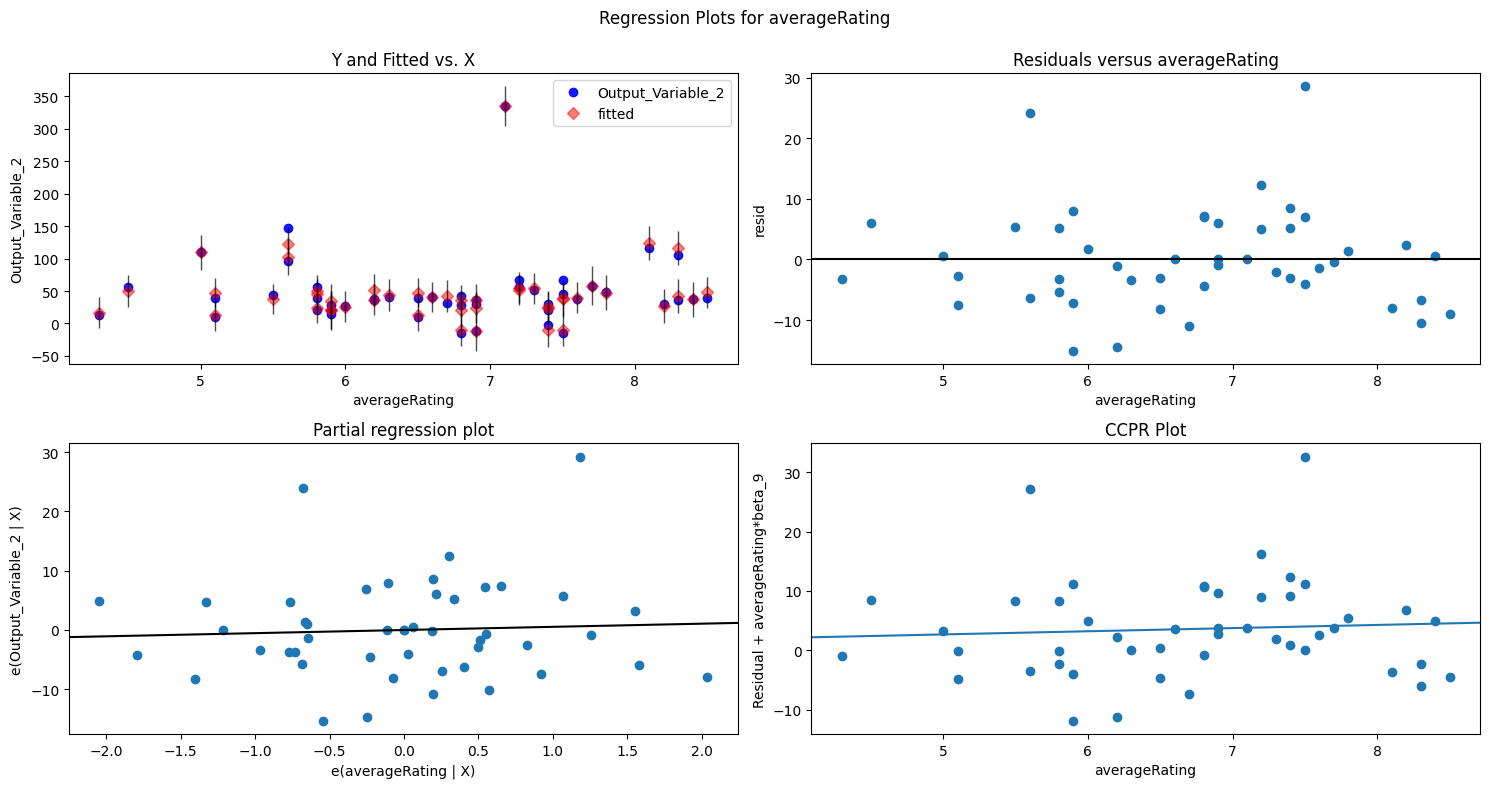

In [696]:
# graph the residuals
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, 'averageRating', fig=fig)

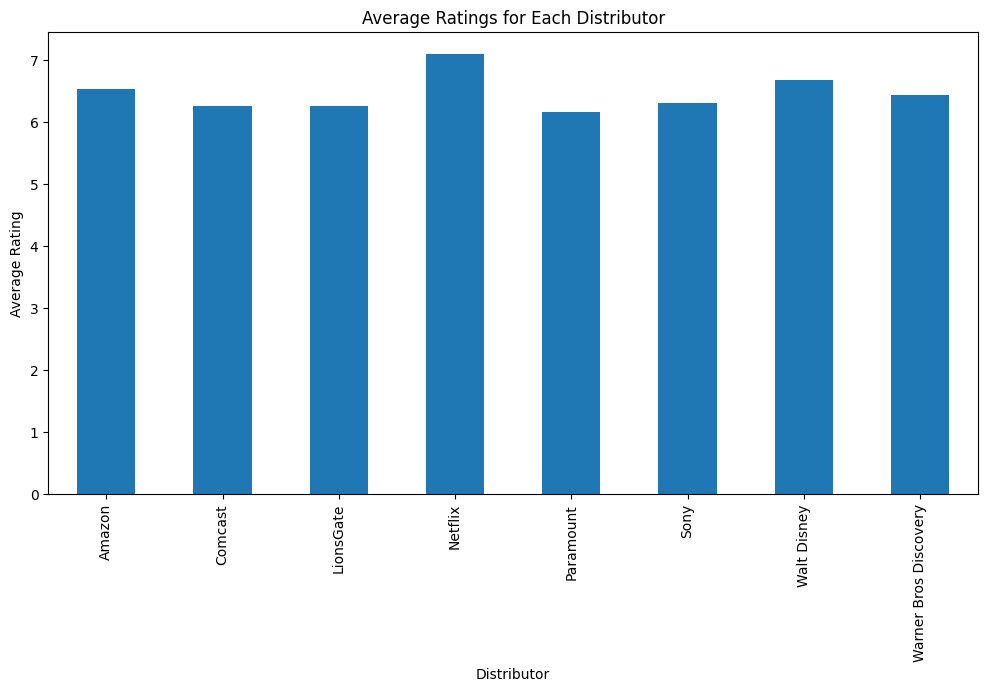

In [698]:
# Calculate the average rating for each distributor
average_ratings = ols_df.groupby('Distributor')['averageRating'].mean()

# Create a bar chart
average_ratings.plot(kind='bar', figsize=(12, 6))

# Set the title and labels
plt.title('Average Ratings for Each Distributor')
plt.xlabel('Distributor')
plt.ylabel('Average Rating')

# Show the plot
plt.show()

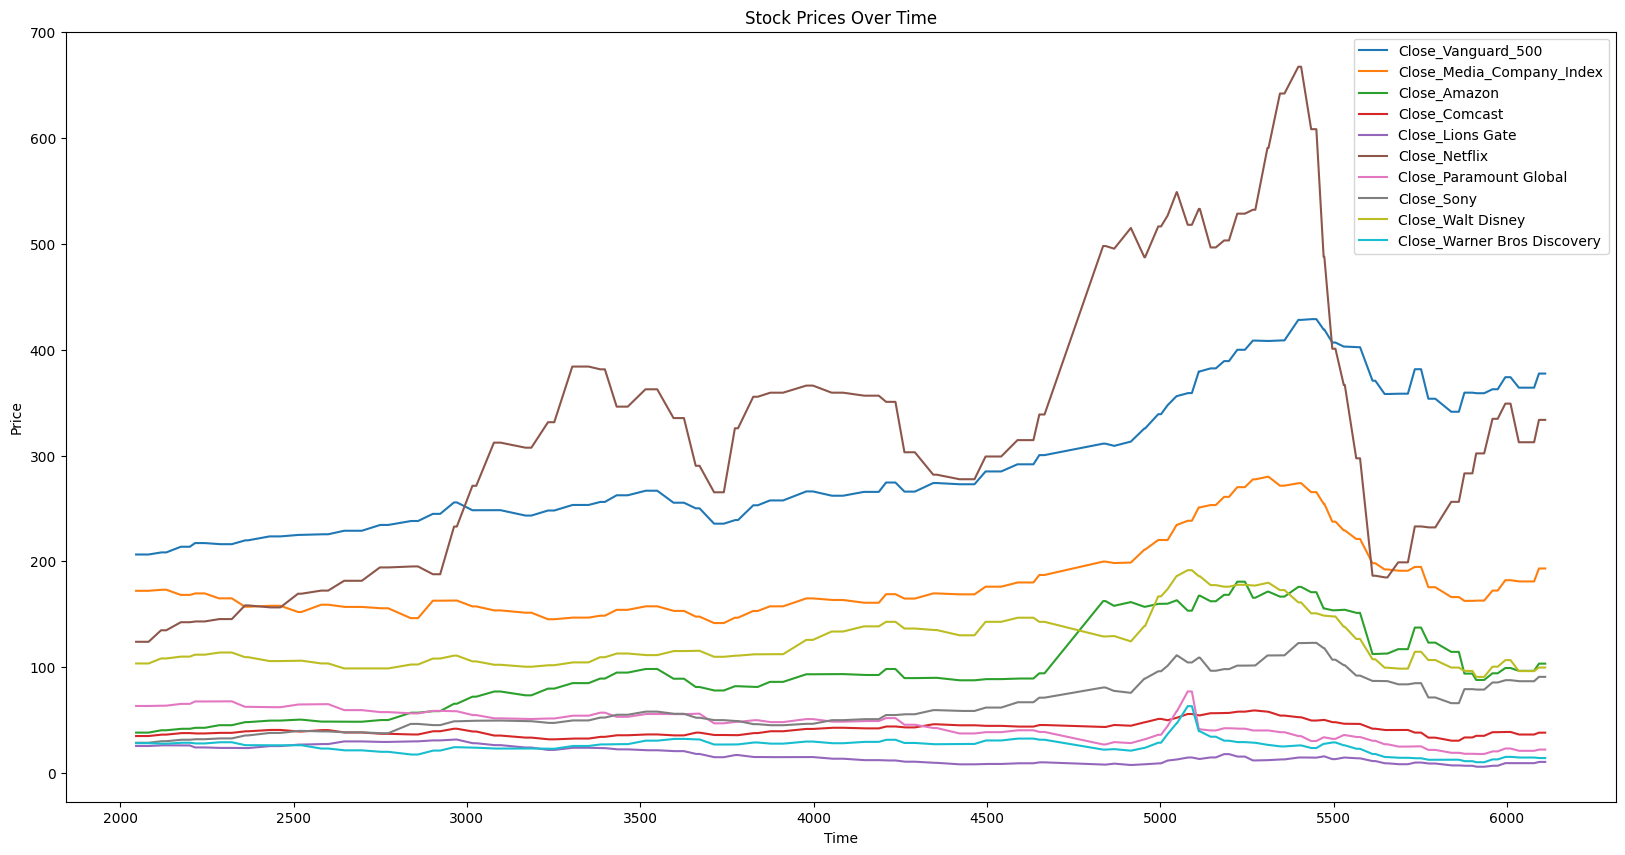

In [707]:
import matplotlib.pyplot as plt

# Plot the stocks
project_dataset[['Close_Vanguard_500', 'Close_Media_Company_Index', 'Close_Amazon', 'Close_Comcast', 'Close_Lions Gate',
       'Close_Netflix', 'Close_Paramount Global', 'Close_Sony',
       'Close_Walt Disney', 'Close_Warner Bros Discovery',]].plot(figsize=(20, 10))

# Set the title and labels
plt.title('Stock Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Price')

# Show the plot
plt.show()

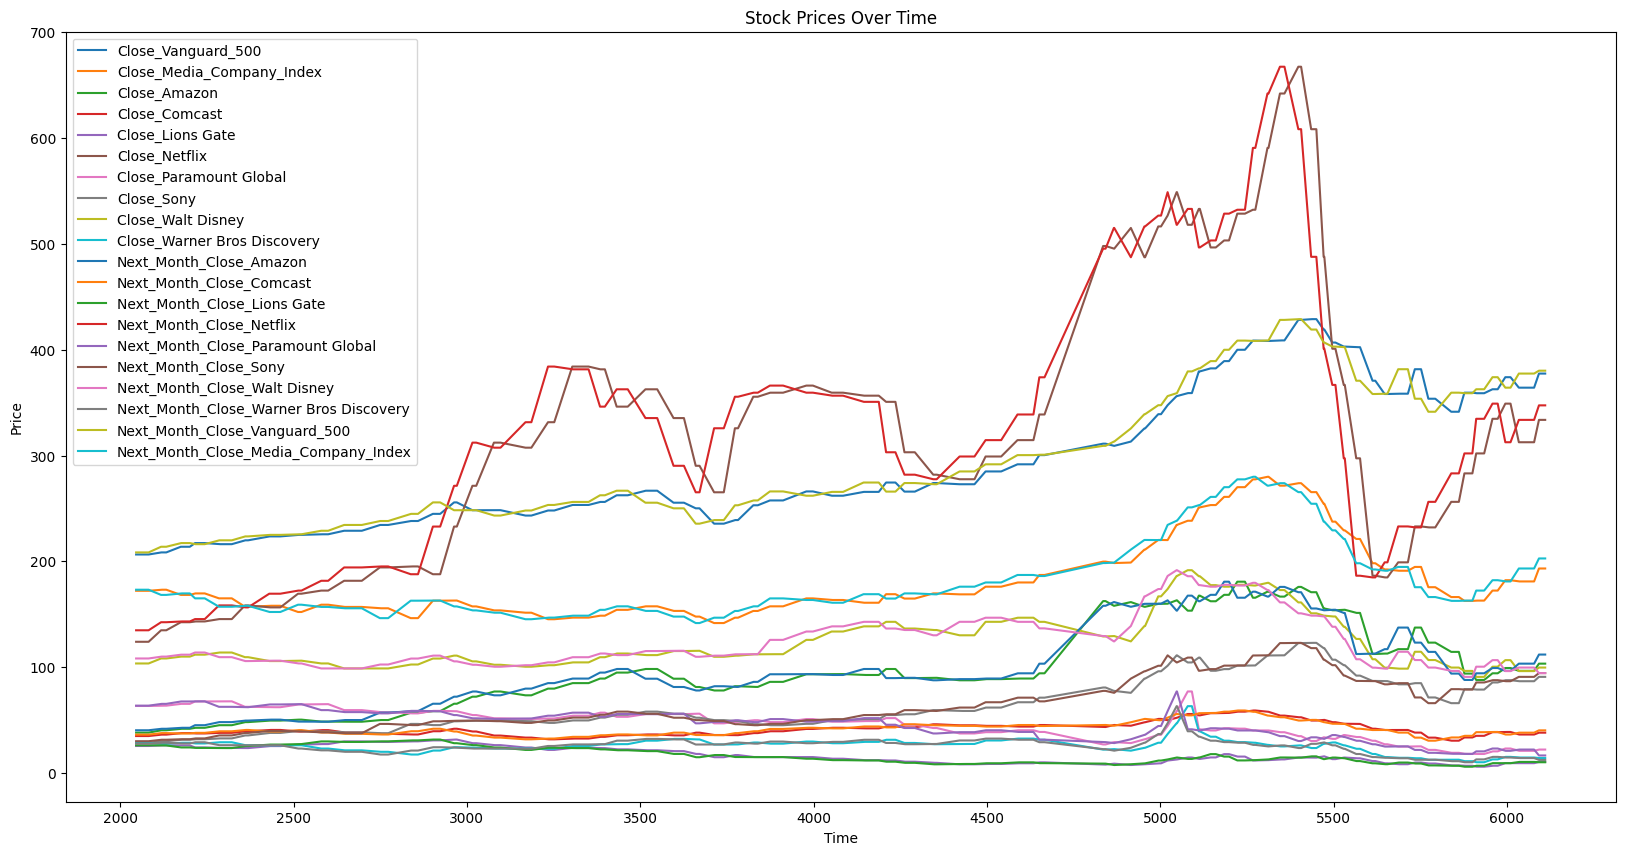

In [706]:
import matplotlib.pyplot as plt

# Plot the stocks
project_dataset[['Close_Vanguard_500', 'Close_Media_Company_Index', 'Close_Amazon', 'Close_Comcast', 'Close_Lions Gate',
       'Close_Netflix', 'Close_Paramount Global', 'Close_Sony',
       'Close_Walt Disney', 'Close_Warner Bros Discovery','Next_Month_Close_Amazon', 'Next_Month_Close_Comcast',
       'Next_Month_Close_Lions Gate', 'Next_Month_Close_Netflix',
       'Next_Month_Close_Paramount Global', 'Next_Month_Close_Sony',
       'Next_Month_Close_Walt Disney',
       'Next_Month_Close_Warner Bros Discovery',
       'Next_Month_Close_Vanguard_500', 'Next_Month_Close_Media_Company_Index']].plot(figsize=(20, 10))

# Set the title and labels
plt.title('Stock Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Price')

# Show the plot
plt.show()

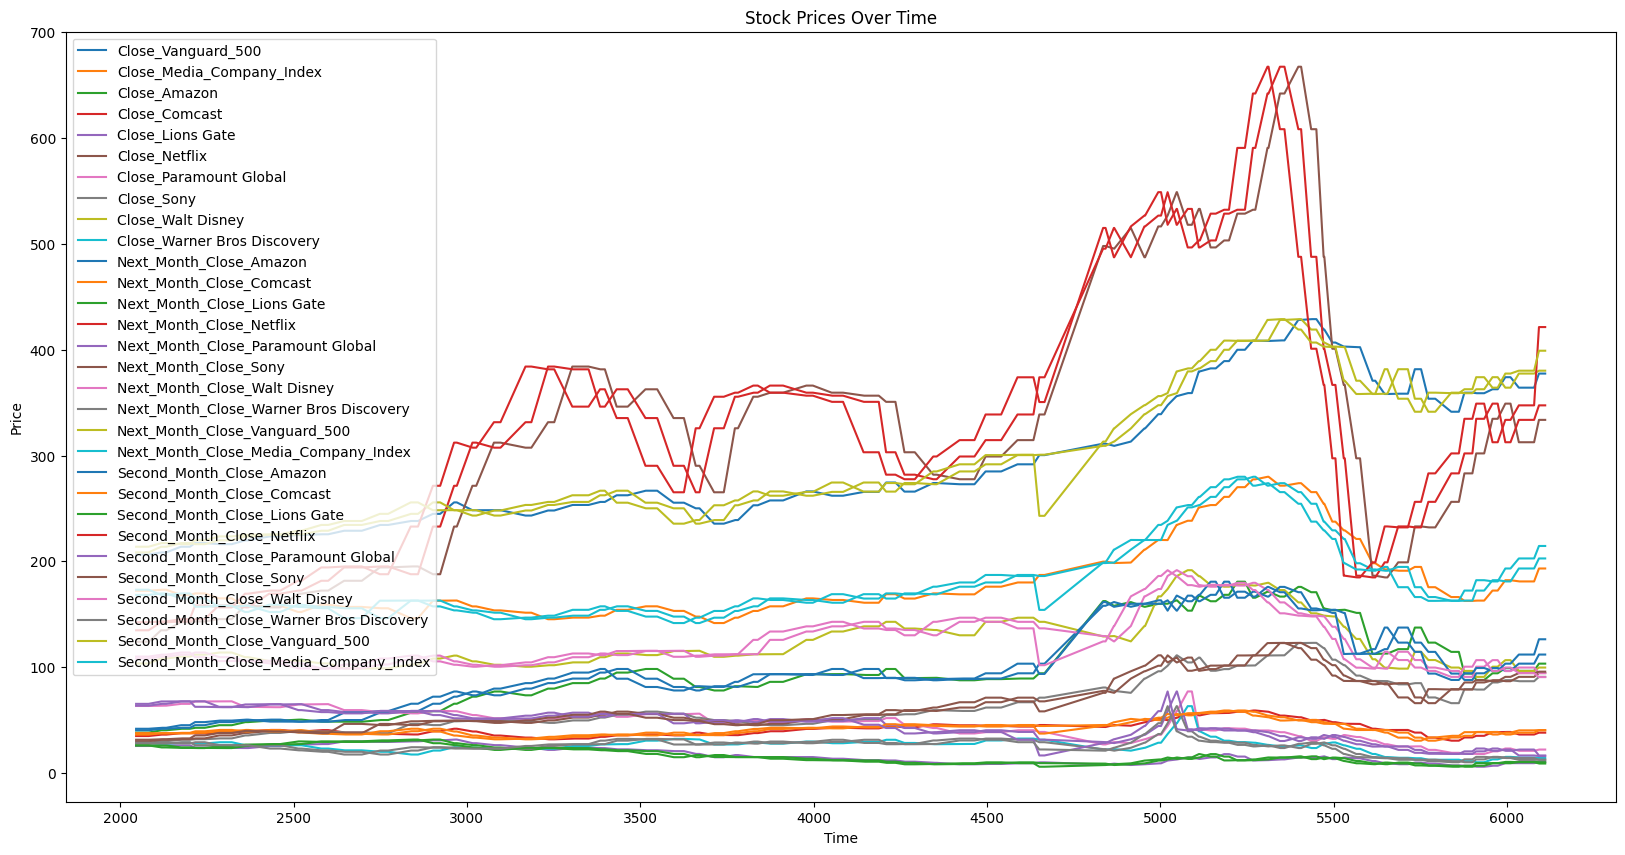

In [705]:
import matplotlib.pyplot as plt

# Plot the stocks
project_dataset[['Close_Vanguard_500', 'Close_Media_Company_Index', 'Close_Amazon', 'Close_Comcast', 'Close_Lions Gate',
       'Close_Netflix', 'Close_Paramount Global', 'Close_Sony',
       'Close_Walt Disney', 'Close_Warner Bros Discovery','Next_Month_Close_Amazon', 'Next_Month_Close_Comcast',
       'Next_Month_Close_Lions Gate', 'Next_Month_Close_Netflix',
       'Next_Month_Close_Paramount Global', 'Next_Month_Close_Sony',
       'Next_Month_Close_Walt Disney',
       'Next_Month_Close_Warner Bros Discovery',
       'Next_Month_Close_Vanguard_500', 'Next_Month_Close_Media_Company_Index','Second_Month_Close_Amazon', 'Second_Month_Close_Comcast',
       'Second_Month_Close_Lions Gate', 'Second_Month_Close_Netflix',
       'Second_Month_Close_Paramount Global', 'Second_Month_Close_Sony',
       'Second_Month_Close_Walt Disney',
       'Second_Month_Close_Warner Bros Discovery',
       'Second_Month_Close_Vanguard_500',
       'Second_Month_Close_Media_Company_Index']].plot(figsize=(20, 10))

# Set the title and labels
plt.title('Stock Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Price')

# Show the plot
plt.show()

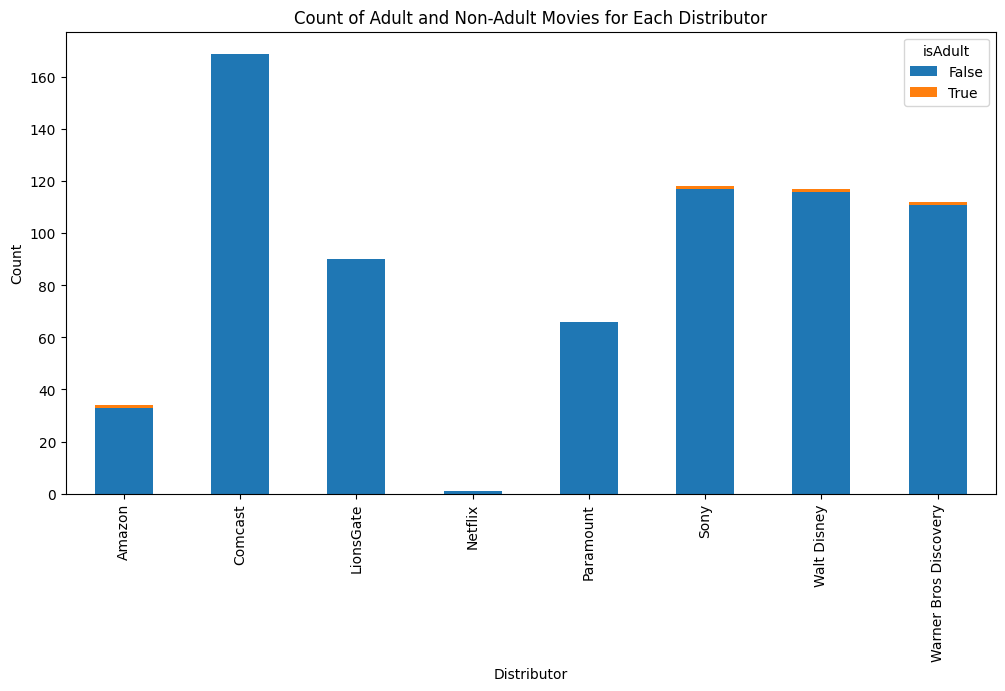

In [708]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of adult and non-adult movies for each distributor
count_isAdult = ols_df.groupby(['Distributor', 'isAdult']).size().unstack()

# Create a grouped bar chart
count_isAdult.plot(kind='bar', stacked=True, figsize=(12, 6))

# Set the title and labels
plt.title('Count of Adult and Non-Adult Movies for Each Distributor')
plt.xlabel('Distributor')
plt.ylabel('Count')

# Show the plot
plt.show()

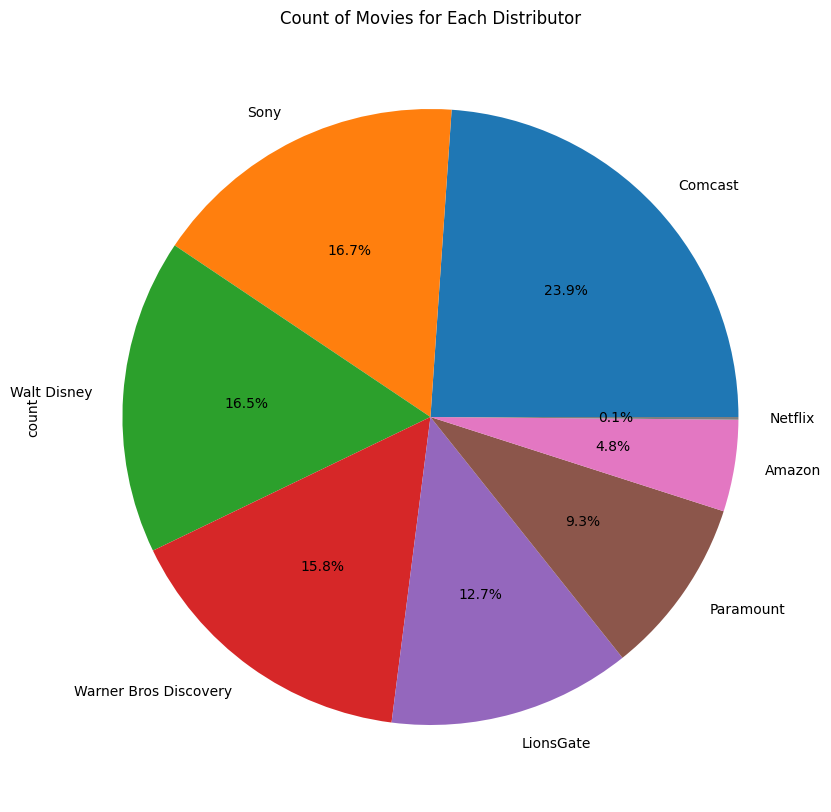

In [709]:
# Count the number of movies for each distributor
distributor_counts = ols_df['Distributor'].value_counts()

# Create a pie chart
distributor_counts.plot(kind='pie', figsize=(10, 10), autopct='%1.1f%%')

# Set the title
plt.title('Count of Movies for Each Distributor')

# Show the plot
plt.show()

Data courtesy of IMDb